In [11]:
from decks.deck import Deck
from decks.io import load_deck_from_txt, fetch_card_data, create_card_from_data, load_deck_from_json
import cards.card
from collections import defaultdict
import re

In [12]:
commander_name, deck_list = load_deck_from_txt("./rawDecks/Davros2.txt")

commander = fetch_card_data(commander_name)

print(commander["color_identity"])
print(commander["type"])
print(commander["subtypes"])

commander=create_card_from_data(commander)

deck= Deck(commander=commander)

for card in deck_list:
    cardToAdd=create_card_from_data(fetch_card_data(card))
    deck.add_card(cardToAdd)

['B', 'R', 'U']
Legendary Artifact Creature 
['Alien', 'Scientist']


In [13]:
deck2= deck.copy() 

In [14]:
print(deck.getNumOfCardsInLibrary())
print(deck2.getNumOfCardsInLibrary())

99
99


In [15]:
deck2.shuffle()

var=deck2.draw(7)
print(var)
for card in var:
    print(card.getName() + " " + str(card.getCmc()))

[Shivan Reef () - Land, Darksteel Ingot ({3}) - Artifact, Perforating Artist ({1}{B}{R}) - Creature , Tectonic Giant ({2}{R}{R}) - Creature , Boltwave ({R}) - Sorcery, Hero's Downfall ({1}{B}{B}) - Instant, Mountain () - Basic Land ]
Shivan Reef 0.0
Darksteel Ingot 3.0
Perforating Artist 3.0
Tectonic Giant 4.0
Boltwave 1.0
Hero's Downfall 3.0
Mountain 0.0


In [16]:
drawn_cards = deck2.draw(5)
print(f"Dobrano {len(drawn_cards)} kart: {[card.getName() for card in drawn_cards]}")


Dobrano 5 kart: ['Reverse the Polarity', 'Maestros Charm', 'Swamp', 'Delete', 'Swamp']


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_turns(deck, num_turns=10, num_trials=1000):

    all_lands = []
    all_cmc = []

    for _ in range(num_trials):
        deck_copy = deck.copy() 
        deck_copy.shuffle()
        lands_per_turn = []
        cmc_per_turn = []
        hand = deck_copy.draw(7)

        for turn in range(num_turns):
            lands = sum(1 for card in hand if "Land" in card.getType())
            cmc_sum = sum(card.cmc for card in hand if card.cmc > 0)
            avg_cmc = cmc_sum / sum(1 for card in hand if card.cmc > 0) if sum(1 for card in hand if card.cmc > 0) else 0

            lands_per_turn.append(lands)
            cmc_per_turn.append(avg_cmc)

            if turn < num_turns -1:
                new_card=deck_copy.draw(1)
                if new_card:
                    hand.extend(new_card)
        all_lands.append(lands_per_turn)
        all_cmc.append(cmc_per_turn)

    avg_lands = np.mean(all_lands, axis=0)
    avg_cmc = np.mean(all_cmc, axis=0)

    return avg_lands, avg_cmc



avg_lands, avg_cmc = simulate_turns(deck2)

print(avg_lands)

print(avg_cmc)


[2.449 2.806 3.161 3.525 3.872 4.238 4.594 4.944 5.291 5.644]
[3.55527619 3.56327024 3.55845476 3.55292341 3.5512039  3.56180418
 3.55135732 3.55687098 3.54955713 3.54851667]


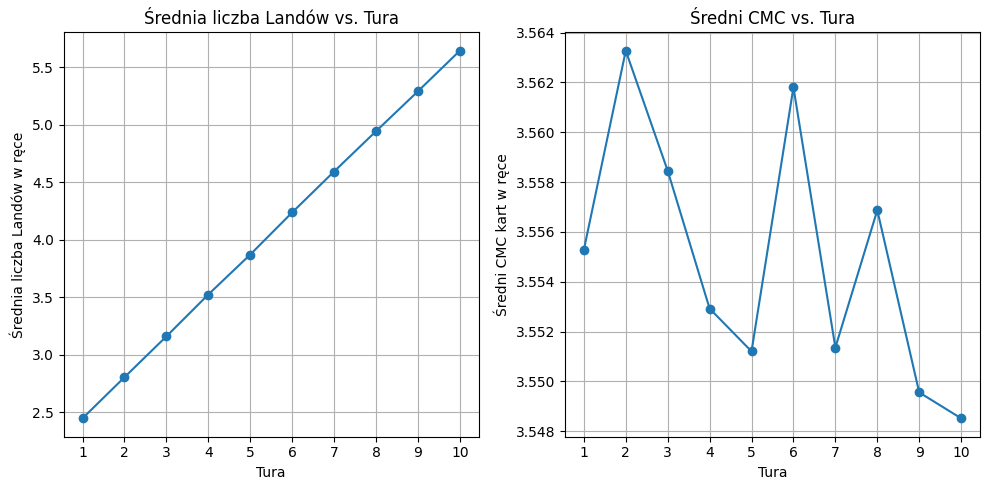

In [18]:
# Tworzenie wykresów
turns = range(1, 11)  # Tury od 1 do 10

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Wykres liczby landów
plt.plot(turns, avg_lands, marker='o')
plt.xlabel("Tura")
plt.ylabel("Średnia liczba Landów w ręce")
plt.title("Średnia liczba Landów vs. Tura")
plt.xticks(turns)
plt.grid(True)

plt.subplot(1, 2, 2)  # Wykres średniego CMC
plt.plot(turns, avg_cmc, marker='o')
plt.xlabel("Tura")
plt.ylabel("Średni CMC kart w ręce")
plt.title("Średni CMC vs. Tura")
plt.xticks(turns)
plt.grid(True)

plt.tight_layout() #Funkcja zapobiega nakładaniu się etykiet
plt.show()


In [19]:
def simulate_turns(deck, commander, num_turns=10, num_trials=1000):
    all_commander_turns = []
    all_mana_production = []
    all_played_nonlands = [] # Dodajemy listę do śledzenia zagranych kart

    for _ in range(num_trials):
        deck_copy = deck.copy()
        deck_copy.shuffle()
        hand = deck_copy.draw(7)
        lands_played = []
        mana_produced = defaultdict(int)
        commander_played = False
        commander_turn = None
        mana_production_per_turn = []
        played_nonlands = [] # Lista zagranych kart w tej próbie

        for turn in range(num_turns):
            mana_this_turn = defaultdict(int)
            for land in lands_played:
                land.state = "Untapped"

            new_card = deck_copy.draw(1)
            if new_card:
                hand.extend(new_card)
            
            for card in hand:
                if "Land" in card.getType() and card not in lands_played:
                    lands_played.append(card)
                    hand.remove(card)
                    if "enter tapped" in card.oracle_text.lower():
                        card.state = "Tapped"
                    break
            
            for land in lands_played:
                if land.state == "Untapped":
                    mana_produced_by_land = re.findall(r"\{([WUBRG]+)\}", land.oracle_text)
                    if mana_produced_by_land:
                        for mana in mana_produced_by_land:
                            for color in mana:
                                mana_this_turn[color]+=1

            if not commander_played:
                commander_cost = commander.getCost()
                can_play_commander = True
                for mana_symbol in re.findall(r"\{([WUBRG]+)\}", commander_cost):
                    for color in mana_symbol:
                        if mana_produced[color] < commander_cost.count("{"+color+"}"):
                            can_play_commander = False
                            break
                    if not can_play_commander:
                        break
                for generic_mana in re.findall(r"\{([0-9]+)\}", commander_cost):
                     generic_mana_int = int(generic_mana)
                     mana_sum = sum(mana_produced.values())
                     if mana_sum<generic_mana_int:
                         can_play_commander = False
                         break
                if can_play_commander:
                    commander_played = True
                    commander_turn = turn + 1
                    played_nonlands.append((commander.name, turn+1)) # Dodajemy Commandera do listy zagranych kart
            
            if not commander_played:
                for card in hand:
                    if card.getManaGain():
                        mana_gained = re.findall(r"\{([WUBRG]+)\}", card.oracle_text)
                        if mana_gained:
                            for mana in mana_gained:
                                for color in mana:
                                    mana_this_turn[color] +=1
                        hand.remove(card)
                        break
            
            #Zagrywanie kart innych niż landy
            cards_to_play = []
            for card in hand:
                if "Land" not in card.getType() and card is not commander:
                    card_cost = card.getCost()
                    can_play_card = True
                    for mana_symbol in re.findall(r"\{([WUBRG]+)\}", card_cost):
                        for color in mana_symbol:
                            if mana_produced[color] < card_cost.count("{"+color+"}"):
                                can_play_card = False
                                break
                        if not can_play_card:
                            break
                    for generic_mana in re.findall(r"\{([0-9]+)\}", card_cost):
                        generic_mana_int = int(generic_mana)
                        mana_sum = sum(mana_produced.values())
                        if mana_sum<generic_mana_int:
                            can_play_card=False
                            break
                    if can_play_card:
                        cards_to_play.append(card)
            for card in cards_to_play:
                hand.remove(card)
                played_nonlands.append((card.name, turn+1))
            

            for color in mana_this_turn:
                mana_produced[color] += mana_this_turn[color]
            mana_production_per_turn.append(mana_produced.copy())

        if commander_turn:
            all_commander_turns.append(commander_turn)
        all_mana_production.append(mana_production_per_turn)
        all_played_nonlands.append(played_nonlands) # Dodajemy listę zagranych kart do głównej listy

    avg_commander_turn = np.mean(all_commander_turns) if all_commander_turns else None

    avg_mana_production = defaultdict(list)
    for turn in range(num_turns):
        turn_data = defaultdict(int)
        for trial_mana in all_mana_production:
            for color, amount in trial_mana[turn].items():
                turn_data[color] += amount
        for color, total in turn_data.items():
            avg_mana_production[color].append(total/num_trials)
    return avg_commander_turn, avg_mana_production, all_played_nonlands

Średnia tura zagrania Commandera: 4.78998778998779


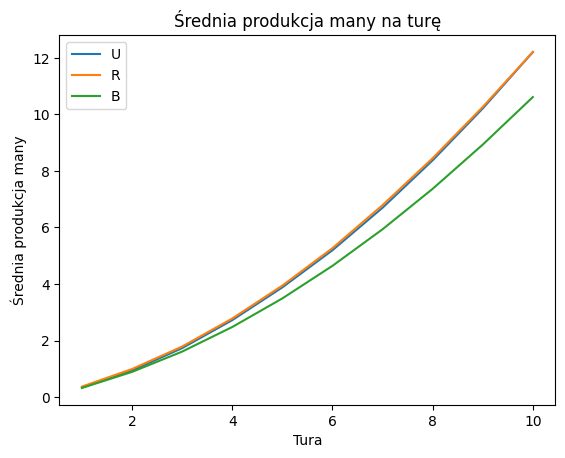

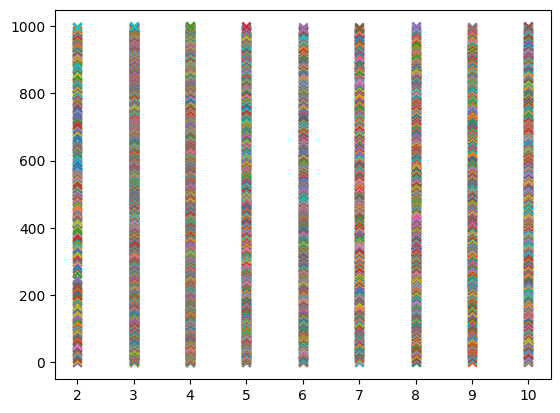

In [20]:

avg_commander_turn, avg_mana_production, all_played_nonlands = simulate_turns(deck, commander)

if avg_commander_turn:
    print(f"Średnia tura zagrania Commandera: {avg_commander_turn}")
else:
    print("Nie udało się zagrać Commandera w żadnym teście.")

turns = range(1, len(list(avg_mana_production.values())[0]) + 1)

for color, production in avg_mana_production.items():
    plt.plot(turns, production, label=color)

plt.xlabel("Tura")
plt.ylabel("Średnia produkcja many")
plt.title("Średnia produkcja many na turę")
plt.legend()

# Tworzenie wykresu dla zagranych kart
plt.figure() # Nowy wykres
for trial, played_cards in enumerate(all_played_nonlands):
    for card_name, turn in played_cards:
        plt.scatter(turn, trial, label=card_name if trial == 0 else None, marker='x') # Dodajemy punkty na wykresie. Etykieta tylko dla pierwszego wystąpienia danej karty

